<a href="https://colab.research.google.com/github/PritishRane/Deep-Learning/blob/main/lstm_healthcare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load the dataset
file_path = '/content/health1234.csv'  # Replace with your file path
try:
    data = pd.read_csv(file_path, encoding='utf-8')
except UnicodeDecodeError:
    data = pd.read_csv(file_path, encoding='latin1')

In [6]:
# Basic data cleaning
print("Initial data shape:", data.shape)
data = data.dropna(subset=['Text'])  # Drop rows with missing 'Text'
print("Data shape after dropping missing values:", data.shape)

Initial data shape: (6988, 3)
Data shape after dropping missing values: (6988, 3)


In [7]:
# Encode target labels
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
data['Tags_encoded'] = label_encoder.fit_transform(data['Tags'])


In [8]:
# Parameters
max_vocab_size = 10000
max_sequence_length = 100
embedding_dim = 100
num_classes = len(data['Tags_encoded'].unique())


In [9]:
def preprocess_data(data, labels, tokenizer=None):
    # Tokenize the text data
    if tokenizer is None:
        tokenizer = Tokenizer(num_words=max_vocab_size, oov_token="<OOV>")
        tokenizer.fit_on_texts(data)

    sequences = tokenizer.texts_to_sequences(data)
    padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post')
    return padded_sequences, labels, tokenizer

In [10]:
# Prepare the dataset
X_train, X_test, y_train, y_test = train_test_split(
    data['Text'], data['Tags_encoded'], test_size=0.2, random_state=42
)

X_train_padded, y_train, tokenizer = preprocess_data(X_train, y_train)
X_test_padded, y_test, _ = preprocess_data(X_test, y_test, tokenizer=tokenizer)

In [11]:
# Build the LSTM model
model = Sequential([
    Embedding(max_vocab_size, embedding_dim, input_length=max_sequence_length),
    LSTM(128, return_sequences=False),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

In [12]:
# Compile the model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [13]:
# Train the model
history = model.fit(
    X_train_padded, y_train,
    validation_data=(X_test_padded, y_test),
    epochs=20,
    batch_size=32
)

Epoch 1/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 42s 217ms/step - accuracy: 0.1391 - loss: 1.9484 - val_accuracy: 0.1402 - val_loss: 1.9489
Epoch 2/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 35s 184ms/step - accuracy: 0.1472 - loss: 1.9471 - val_accuracy: 0.1416 - val_loss: 1.9463
Epoch 3/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 41s 183ms/step - accuracy: 0.1453 - loss: 1.9470 - val_accuracy: 0.1316 - val_loss: 1.9462
Epoch 4/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 41s 183ms/step - accuracy: 0.1457 - loss: 1.9466 - val_accuracy: 0.1373 - val_loss: 1.9460
Epoch 5/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 41s 183ms/step - accuracy: 0.1420 - loss: 1.9477 - val_accuracy: 0.1338 - val_loss: 1.9462
Epoch 6/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 41s 184ms/step - accuracy: 0.1534 - loss: 1.9447 - val_accuracy: 0.1345 - val_loss: 1.9436
Epoch 7/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 43s 197ms/step - accuracy: 0.1406 - loss: 1.9429 - val_accuracy: 0.1459 - val_loss: 1.9433
Epoch 8/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 38s 183ms/step - accuracy: 0.1542 - loss: 1

In [14]:
# Evaluate the model
evaluation = model.evaluate(X_test_padded, y_test)
print(f"Test Loss: {evaluation[0]}, Test Accuracy: {evaluation[1]}")

44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.1306 - loss: 1.9417
Test Loss: 1.9422355890274048, Test Accuracy: 0.13447782397270203


In [15]:
# Predictions and Metrics
y_pred_probs = model.predict(X_test_padded)
y_pred = np.argmax(y_pred_probs, axis=1)

44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step


In [16]:
# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))



Classification Report:

              precision    recall  f1-score   support

         Emo       0.00      0.00      0.00       189
         Env       0.00      0.00      0.00       196
       Intel       0.00      0.00      0.00       216
         Nut       0.00      0.00      0.00       208
         Phy       0.83      0.02      0.05       204
         Soc       0.00      0.00      0.00       202
        Spir       0.13      1.00      0.23       183

    accuracy                           0.13      1398
   macro avg       0.14      0.15      0.04      1398
weighted avg       0.14      0.13      0.04      1398



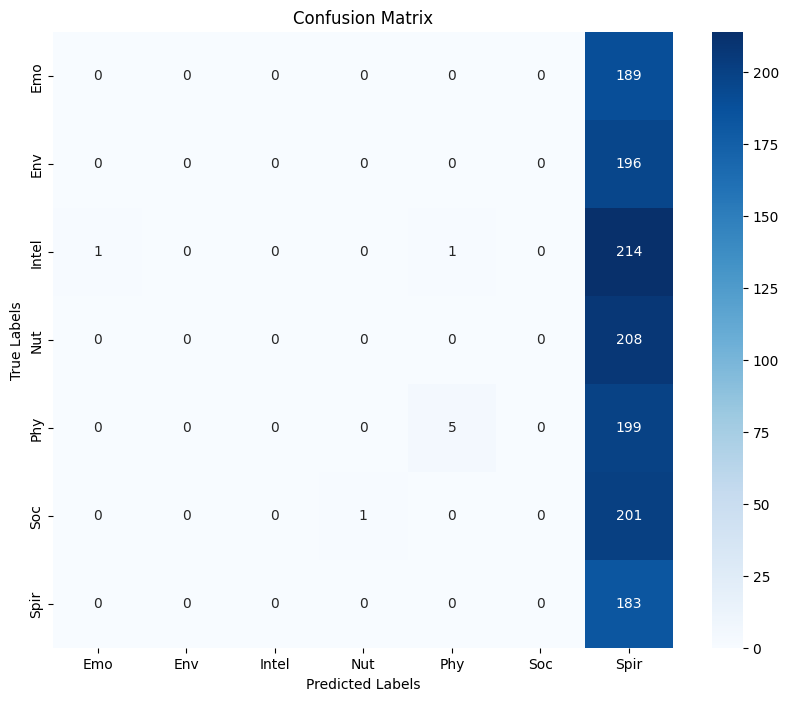

In [17]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()


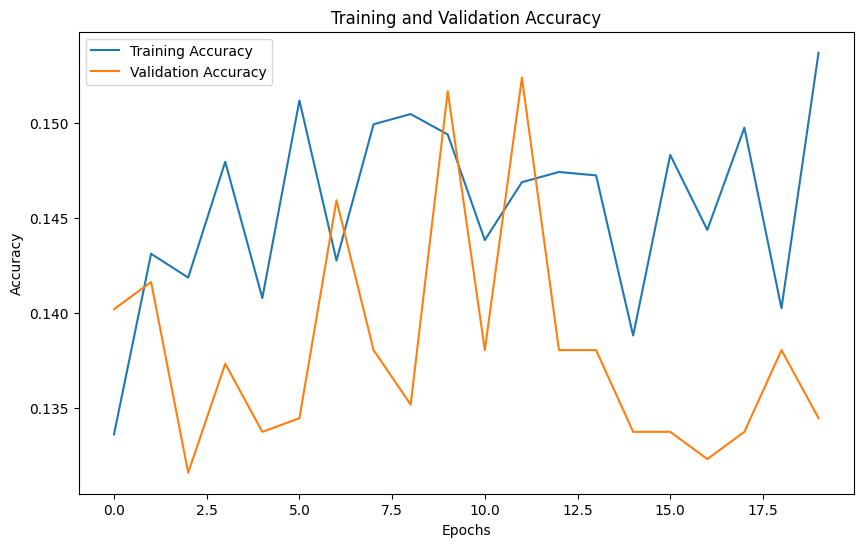

In [18]:
# Plot Training and Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

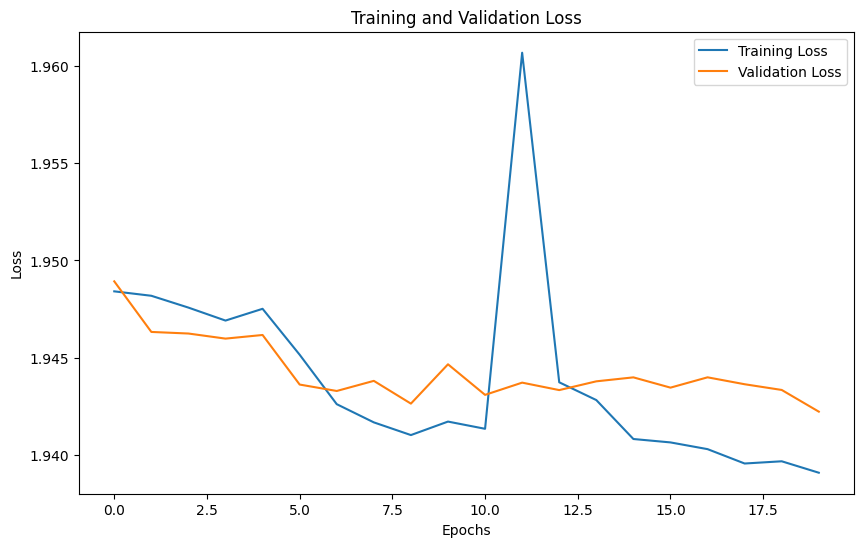

In [19]:
# Plot Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [20]:
# Accuracy Score
accuracy = accuracy_score(y_test, y_pred)
print(f"Overall Test Accuracy: {accuracy}")

Overall Test Accuracy: 0.13447782546494993


In [21]:

# Save the model
model.save('lstm_model.keras')